In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from numpy import array 
##Removes warning for chained assignments
pd.options.mode.chained_assignment = None  # default='warn'

2022-09-01 20:57:09.230790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 20:57:09.230856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
def create_sequences(df,period):
    #Create Time Lags
    for i in range(1,period+1):
        df[f't-{i}'] = df[df.columns[0]].shift(i)
    df.dropna(inplace = True)
    
    #create sequences
    X = []
    for i in range(len(df[df.columns[0]])):
        arr = []
        for j in range(1,df.shape[1]):
            arr.append(df[f't-{j}'][i])
        X.append(arr)
    y = df[df.columns[0]].tolist()
    X = array(X)
    y= array(y)
    #returns shaped X and y 
    return X.reshape((X.shape[0], X.shape[1], 1)),y

In [17]:
def split(X,y,test_size = 20 ):
    X_train = X[0:X.shape[0]-test_size]
    y_train = y[0:y.shape[0]-test_size]
    X_test = X[X.shape[0]-test_size:]
    y_test = y[y.shape[0]-test_size:]
    return (X_train,y_train,X_test,y_test)

In [18]:
df = pd.read_csv('../raw_data/ratios.csv')
df

,Date,ALB_ZBRA,NRG_CPRT,DE_BXP,NRG_STE,NRG_XRAY,SO_NLOK,PEG_O
0,2020-08-31,0.311845,0.310544,2.548054,0.203834,0.727693,2.136432,0.882281
1,2020-09-01,0.332974,0.306303,2.687319,0.203522,0.722940,2.094566,0.855546
2,2020-09-02,0.332368,0.315056,2.629334,0.204743,0.734758,2.125291,0.872526
3,2020-09-03,0.339772,0.310060,2.534974,0.201707,0.728923,2.210971,0.848504
4,2020-09-04,0.356920,0.300754,2.536138,0.199887,0.707646,2.152835,0.854765
...,...,...,...,...,...,...,...,...
492,2022-08-15,0.813028,0.321488,4.111073,0.197467,1.123670,3.277218,0.920803
493,2022-08-16,0.814154,0.323634,4.118669,0.200499,1.158238,3.283272,0.933379
494,2022-08-17,0.815450,0.327442,4.154118,0.201342,1.191888,3.347435,0.935173
495,2022-08-18,0.816374,0.333768,4.222490,0.204492,1.196920,3.371537,0.950678


In [19]:
df.set_index('Date',inplace=True)

In [20]:
#Model 

In [21]:
model = Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(20,1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mae')

In [22]:
def run_model(model,X_train,y_train,X_test):
    model.fit(X_train,y_train, epochs=100, verbose=0)
    preds = []
    for i in range(len(X_test)):    
        pred = model.predict(X_test[i].reshape(1,20,1))
        preds.append(pred[0][0])
    return preds

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
frames = []
for column in df:
    frames.append(pd.DataFrame(df[column]))


In [46]:
predictions = []
X_trains = []
y_trains = []
X_tests = []
y_tests=[]
for frame in frames: 
    X,y = create_sequences(frame,20)
    X_train,y_train,X_test,y_test = split(X,y)
    preds = run_model(model,X_train,y_train,X_test)
    predictions.append(preds)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

1/1 [==============================] - 0s 26ms/step


In [ ]:
y_tests

In [47]:
frames[0][frames[0].columns[0]]

Date
2020-11-24    0.362261
2020-11-25    0.356290
2020-11-27    0.359915
2020-11-30    0.354162
2020-12-01    0.359872
                ...   
2022-08-15    0.813028
2022-08-16    0.814154
2022-08-17    0.815450
2022-08-18    0.816374
2022-08-19    0.822204
Name: ALB_ZBRA, Length: 437, dtype: float64

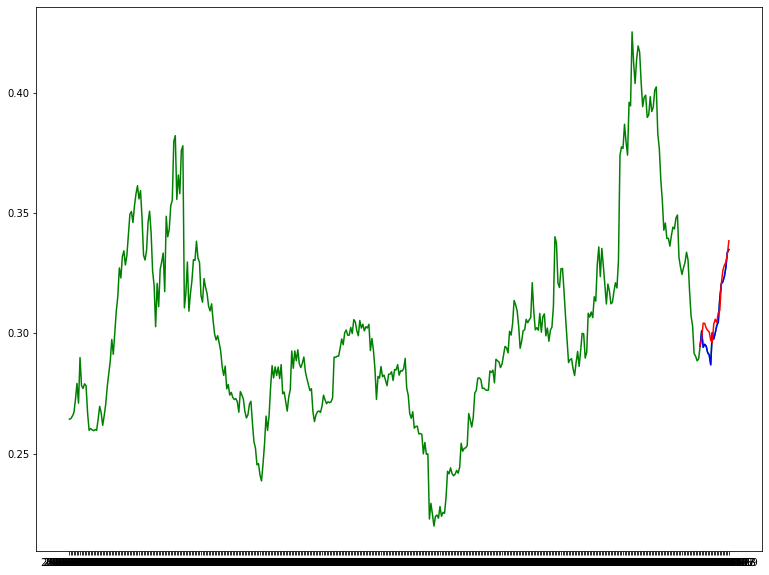

In [49]:
number = 1
fig, ax = plt.subplots(1,1,figsize = (13,10))
ax.plot(frames[number][frames[number].columns[0][0:457]],color='green')
ax.plot(frames[number].index[-20:],y_tests[number],color='blue')
ax.plot(frames[number].index[-20:],predictions[number-0],color='red')

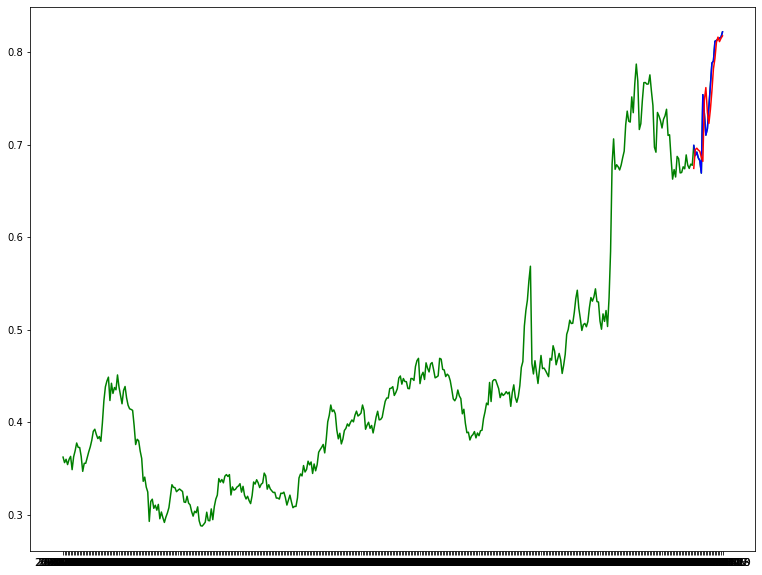

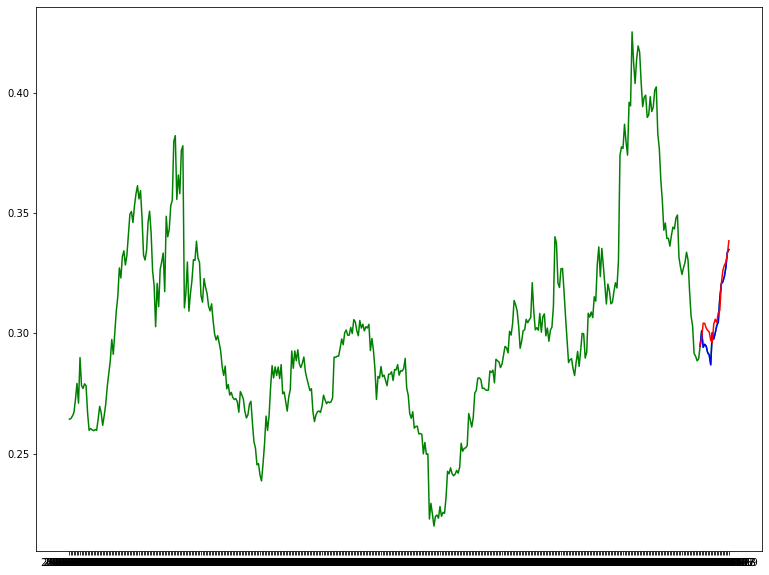

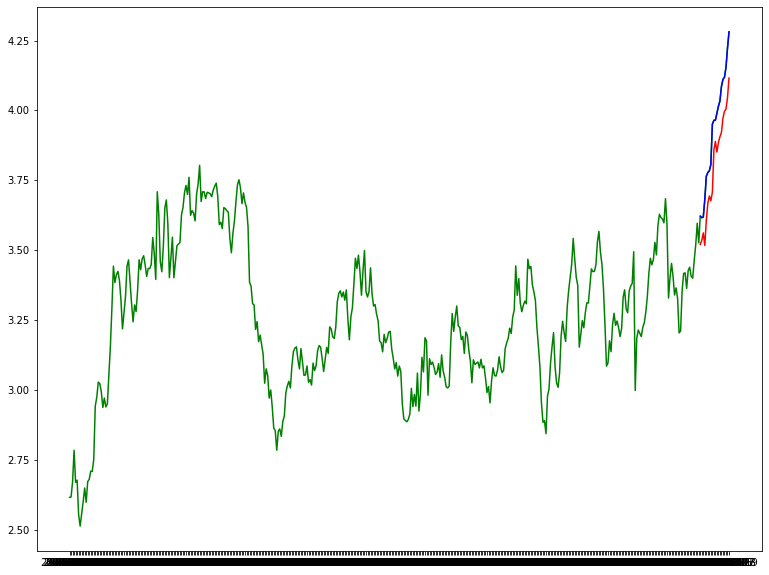

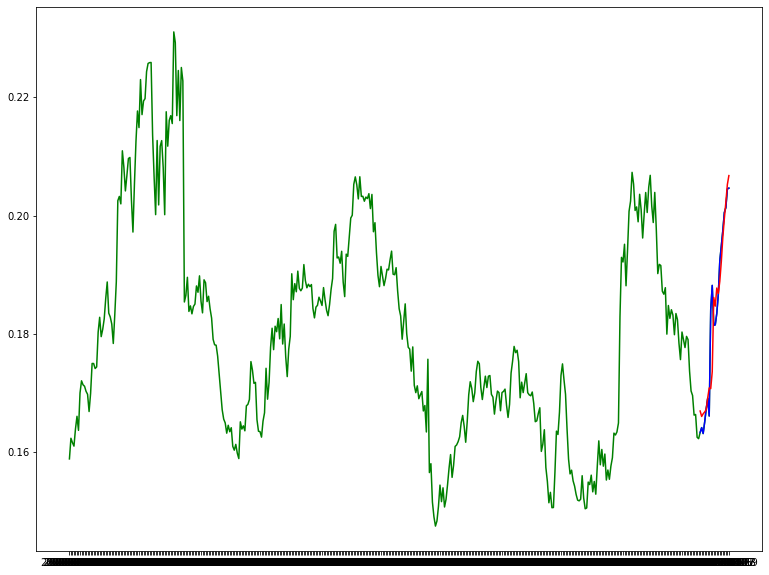

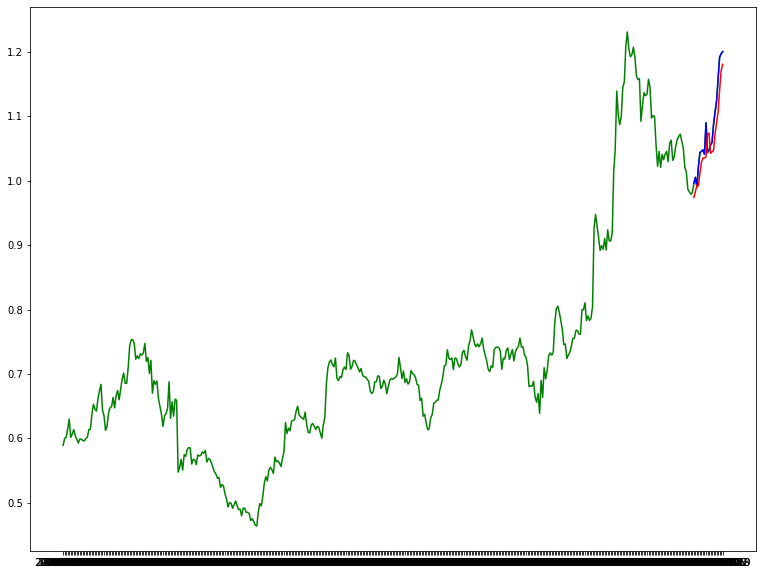

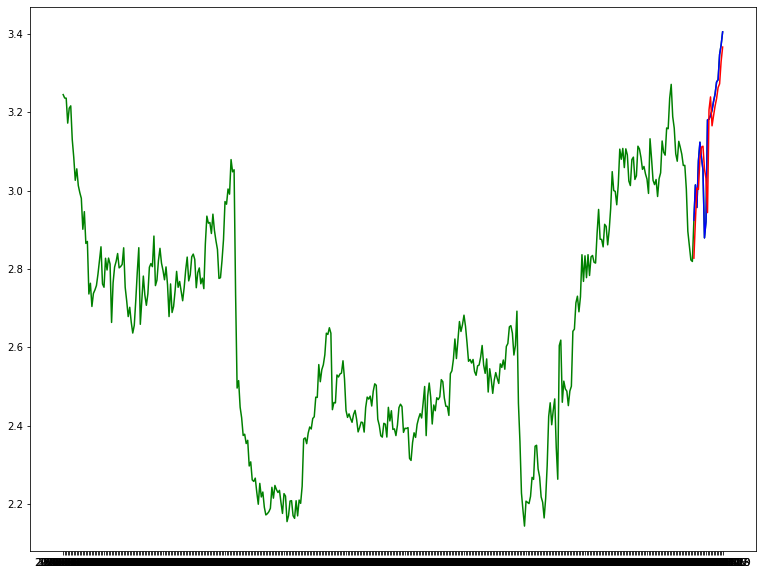

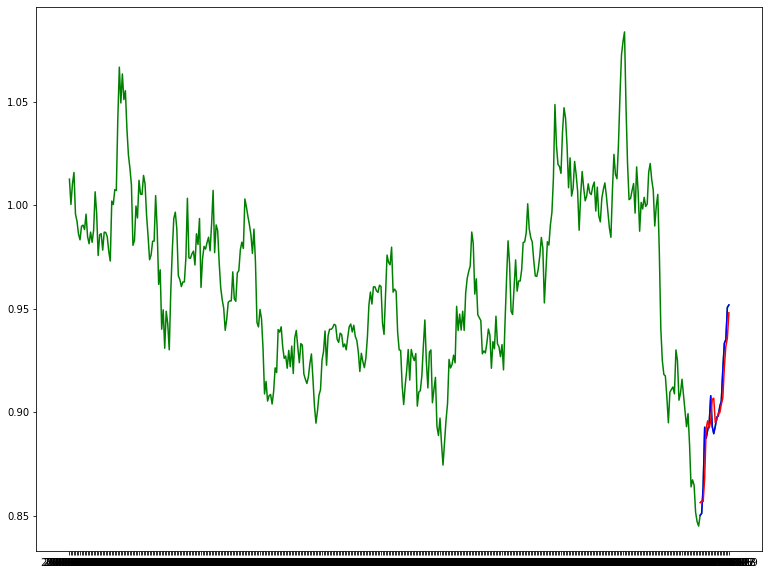

In [50]:
for number in range(7):
    fig, ax = plt.subplots(1,1,figsize = (13,10))
    ax.plot(frames[number][frames[number].columns[0][0:457]],color='green')
    ax.plot(frames[number].index[-20:],y_tests[number],color='blue')
    ax.plot(frames[number].index[-20:],predictions[number-0],color='red')